In [33]:
from csv import writer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error

In [45]:
def plot_train_progress_1(loss_train, loss_test, iters_per_point, total_iters=None):

    fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
    x_points = range(0, len(loss_train)*iters_per_point, iters_per_point)
    
    axes.plot(x_points, loss_train, color="red", label="Training loss", linewidth=1)
    axes.plot(x_points, loss_test, color="blue", label="Test loss", linewidth=1)
    axes.set_title("Training loss", fontsize=10, y=1.022)
    axes.yaxis.grid(True, zorder=0)
    axes.set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes.set_xlim([0,total_iters])
    axes.set_ylim([0,None])
    axes.legend(loc='upper right')
    plt.show()

def get_random_batch(train_features, train_lbls, batch_size, rng):

    indices = range(0, batch_size)
    indices = rng.randint(low=0, high=train_features.shape[0], size=batch_size, dtype='int32')
    
    train_features_batch = train_features[indices]
    if train_lbls is not None:
        train_lbls_batch = train_lbls[indices]
    else:
        train_lbls_batch = None
    return [train_features_batch, train_lbls_batch]

def training_network(net,
                    loss_func,
                    rng,
                    train_inputs_all,
                    train_labels_all,
                    test_values_all,
                    test_labels_all,
                    batch_size,
                    learning_rate,
                    total_iters,
                    iters_per_recon_plot=-1):

    values_to_plot = {'loss_train':[], 'loss_test': []}
    
    optimizer = torch.optim.Adam(net.params, lr=learning_rate)
        
    for t in range(total_iters):
        x_imgs, x_targets = get_random_batch(train_inputs_all, train_labels_all, batch_size, rng)

        x_pred = net.forward_pass(x_imgs)

        loss = loss_func(x_pred, x_targets)
        
        optimizer.zero_grad()
        gradient = net.backward_pass(loss)
        optimizer.step()
        
        loss_np = loss if type(loss) is type(float) else loss.item()
        if(t % iters_per_recon_plot == 0):
            x_test_pred = net.forward_pass(test_values_all)
            loss = loss_func(x_test_pred, test_labels_all)
            loss_test = loss if type(loss) is type(float) else loss.item()
            values_to_plot['loss_train'].append(loss_np)
            values_to_plot['loss_test'].append(loss_test)
            
    plot_train_progress_1(values_to_plot['loss_train'], values_to_plot['loss_test'], iters_per_point=1)

In [40]:
class Network():
    
    def backward_pass(self, loss):
        loss.backward()
        grads = [param.grad for param in self.params]
        return grads
    
class Three_layer_network(Network):
    def __init__(self, rng, D_in, D_hid_1):
        D_in = D_in
        D_out = 1

        w1_init = rng.normal(loc=0.0, scale=0.001, size=(D_in+1, D_hid_1))
        w2_init = rng.normal(loc=0.0, scale=0.001, size=(D_hid_1+1, D_out))

        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)

        self.params = [w1, w2]
        
        
    def forward_pass(self, batch_inputs):

        [w1, w2] = self.params

        
        batch_inputs_t = torch.tensor(batch_inputs, dtype=torch.float)
        
        unary_feature_for_bias = torch.ones(size=(batch_inputs.shape[0], 1))
        x = torch.cat((batch_inputs_t, unary_feature_for_bias), dim=1)
    
        h1_preact = x.mm(w1)
        h1_act = h1_preact.clamp(min=0)

        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)
        h2_act = h2_preact

        x_pred = h2_act

                
        return x_pred
        
        
def MSE_loss(x_pred, x_real, eps=1e-7):

    x_pred = torch.tensor(x_pred, dtype=torch.float) if type(x_pred) is np.ndarray else x_pred
    x_real = torch.tensor(x_real, dtype=torch.float) if type(x_real) is np.ndarray else x_real

    loss_recon = torch.mean(torch.square((x_pred - x_real)), dim=1)

    cost = torch.mean(loss_recon)
    return cost

In [36]:
def evaluate(x_test, y_test):
    y_pred = network.forward_pass(x_test)

    with torch.no_grad():
        y_pred = y_pred.numpy()

    avg_abs_per_error = mean_absolute_percentage_error(y_test, y_pred)
    avg_abs_error = mean_absolute_error(y_test, y_pred)
    avg_mean_sq_error = root_mean_squared_error(y_test, y_pred)

    print(f"Mean absolute percentage error: {avg_abs_per_error}")
    print(f"Mean absolute error: {avg_abs_error}")
    print(f"Mean root mean squared error: {avg_mean_sq_error}")

    return np.array([avg_abs_per_error, avg_abs_error, avg_mean_sq_error])

In [ ]:
file = "corona"
#file = "jpeg-large"
#file = "smallbank-1"
#file = "beethoven.wav"
#file = "ambivert"
#file = "ambivert.wav.tar"
#file = "Johnny_1280x720_60_short.y4m"
#file = "artificl.tar"
#file = "AUFNIRA_z3.637557.smt2"

data = pd.read_csv("C:/Users/nicho/Downloads/ISE coursework/Data sets/"+ file +".csv")
data_array = data.to_numpy()
print(f"Training network for {file} dataset")

x = data_array[:,:-1]
y = data_array[:,-1:]

features =  x.shape[1]
hidden = int(features * 7.5)
batch = int(x.shape[0] / 50)
rng = np.random.RandomState(seed=111111)
lr = 0
if file in ["Johnny_1280x720_60_short.y4m", "ambivert.wav.tar", "jpeg-large", "corona", "ambivert"]:
    lr = 3e-5
else:
    lr = 3e-3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
network = Three_layer_network(rng=rng,
                            D_in=features,
                            D_hid_1=hidden)
training_network(network,
        MSE_loss,
        rng,
        x_train,
        y_train,
        x_test,
        y_test,
        batch_size=batch,
        learning_rate=lr,
        total_iters=300000,
        iters_per_recon_plot=1000)
print("Evaluating error on test set:")
evaluate(x_test, y_test)

Training network for corona dataset


Running for corona
[iter: 0 ]: Training Loss: 790.9361
[iter: 25000 ]: Training Loss: 0.2075
[iter: 50000 ]: Training Loss: 0.1626
[iter: 75000 ]: Training Loss: 0.2026
[iter: 100000 ]: Training Loss: 0.0963
[iter: 125000 ]: Training Loss: 0.1341
[iter: 150000 ]: Training Loss: 0.0795
[iter: 175000 ]: Training Loss: 0.0667
[iter: 200000 ]: Training Loss: 0.1305
[iter: 225000 ]: Training Loss: 0.1005
[iter: 250000 ]: Training Loss: 0.0270
[iter: 275000 ]: Training Loss: 0.0518


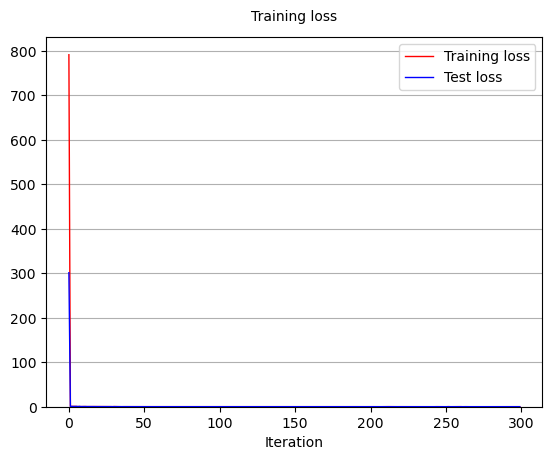

Evaluating error for corona network on test set:
Mean absolute percentage error: 0.12826147252282716
Mean absolute error: 0.20904152929782865
Mean root mean squared error: 0.3375774142603626
Running for jpeg-large
[iter: 0 ]: Training Loss: 10.4405
[iter: 25000 ]: Training Loss: 0.0307
[iter: 50000 ]: Training Loss: 0.0105
[iter: 75000 ]: Training Loss: 0.0112
[iter: 100000 ]: Training Loss: 0.0098
[iter: 125000 ]: Training Loss: 0.0113
[iter: 150000 ]: Training Loss: 0.0129
[iter: 175000 ]: Training Loss: 0.0144
[iter: 200000 ]: Training Loss: 0.0193
[iter: 225000 ]: Training Loss: 0.0130
[iter: 250000 ]: Training Loss: 0.0109
[iter: 275000 ]: Training Loss: 0.0146


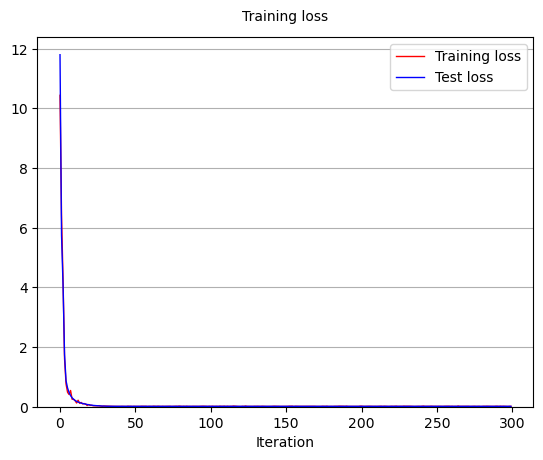

Evaluating error for jpeg-large network on test set:
Mean absolute percentage error: 0.026902173932484254
Mean absolute error: 0.08617500455508677
Mean root mean squared error: 0.1158754530274576
Running for smallbank-1
[iter: 0 ]: Training Loss: 396889824.0000
[iter: 25000 ]: Training Loss: 1789406.1250
[iter: 50000 ]: Training Loss: 1190311.7500
[iter: 75000 ]: Training Loss: 2246718.7500
[iter: 100000 ]: Training Loss: 1985983.1250
[iter: 125000 ]: Training Loss: 1964196.2500
[iter: 150000 ]: Training Loss: 1821676.7500
[iter: 175000 ]: Training Loss: 1729168.3750
[iter: 200000 ]: Training Loss: 1764372.7500
[iter: 225000 ]: Training Loss: 2053654.0000
[iter: 250000 ]: Training Loss: 1792920.2500
[iter: 275000 ]: Training Loss: 1660774.6250


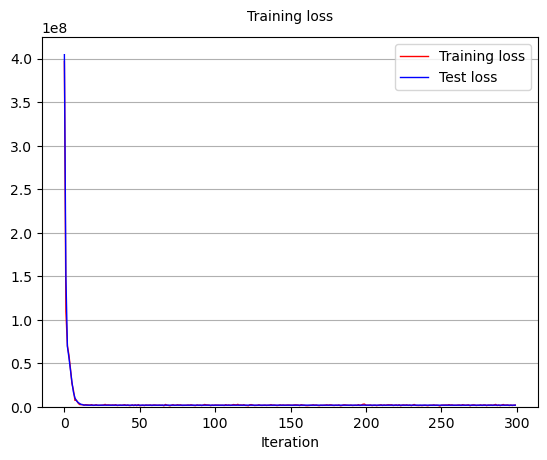

Evaluating error for smallbank-1 network on test set:
Mean absolute percentage error: 0.05715435897700374
Mean absolute error: 1118.056666141963
Mean root mean squared error: 1335.133876002542
Running for beethoven.wav
[iter: 0 ]: Training Loss: 145.4179
[iter: 25000 ]: Training Loss: 5.8714
[iter: 50000 ]: Training Loss: 4.8968
[iter: 75000 ]: Training Loss: 3.9450
[iter: 100000 ]: Training Loss: 3.4806
[iter: 125000 ]: Training Loss: 2.8321
[iter: 150000 ]: Training Loss: 5.9051
[iter: 175000 ]: Training Loss: 3.2787
[iter: 200000 ]: Training Loss: 4.2459
[iter: 225000 ]: Training Loss: 2.7566
[iter: 250000 ]: Training Loss: 2.3471
[iter: 275000 ]: Training Loss: 5.3289


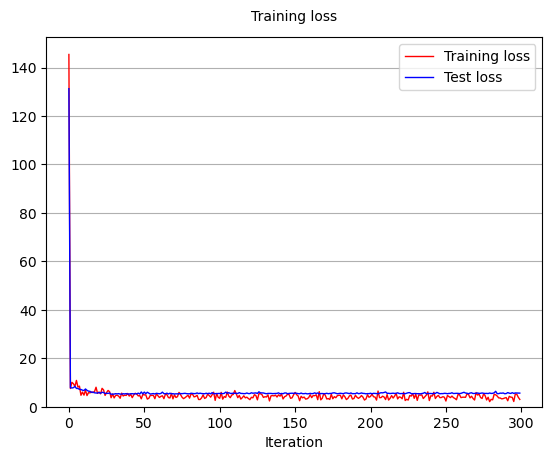

Evaluating error for beethoven.wav network on test set:
Mean absolute percentage error: 0.18792009930260692
Mean absolute error: 1.7404047303658043
Mean root mean squared error: 2.418961825581089
Running for ambivert
[iter: 0 ]: Training Loss: 296725088.0000
[iter: 25000 ]: Training Loss: 1778.8760
[iter: 50000 ]: Training Loss: 1016.9713
[iter: 75000 ]: Training Loss: 1345.6569
[iter: 100000 ]: Training Loss: 835.7360
[iter: 125000 ]: Training Loss: 476.8827
[iter: 150000 ]: Training Loss: 490.9905
[iter: 175000 ]: Training Loss: 467.7592
[iter: 200000 ]: Training Loss: 290.7241
[iter: 225000 ]: Training Loss: 383.8080
[iter: 250000 ]: Training Loss: 330.5999
[iter: 275000 ]: Training Loss: 222.1297


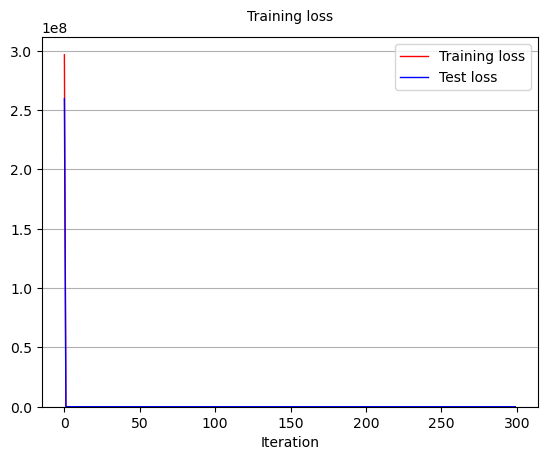

Evaluating error for ambivert network on test set:
Mean absolute percentage error: 0.6376298474456379
Mean absolute error: 11.603331893042963
Mean root mean squared error: 18.61265634374703
Running for ambivert.wav.tar
[iter: 0 ]: Training Loss: 33.0444
[iter: 25000 ]: Training Loss: 1537.9340
[iter: 50000 ]: Training Loss: 65.2828
[iter: 75000 ]: Training Loss: 65.1114
[iter: 100000 ]: Training Loss: 53.6843
[iter: 125000 ]: Training Loss: 71.9952
[iter: 150000 ]: Training Loss: 1494.6364
[iter: 175000 ]: Training Loss: 13.1217
[iter: 200000 ]: Training Loss: 38.9093
[iter: 225000 ]: Training Loss: 22.8621
[iter: 250000 ]: Training Loss: 104.8564
[iter: 275000 ]: Training Loss: 1311.3615


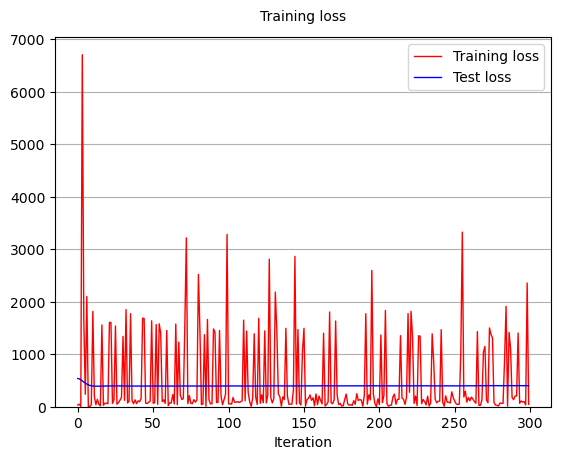

Evaluating error for ambivert.wav.tar network on test set:
Mean absolute percentage error: 1.6738026733312115
Mean absolute error: 12.334694956746596
Mean root mean squared error: 20.065130313614112
Running for Johnny_1280x720_60_short.y4m
[iter: 0 ]: Training Loss: 114.9578
[iter: 25000 ]: Training Loss: 3.7423
[iter: 50000 ]: Training Loss: 5.8154
[iter: 75000 ]: Training Loss: 3.2997
[iter: 100000 ]: Training Loss: 3.7654
[iter: 125000 ]: Training Loss: 4.5859
[iter: 150000 ]: Training Loss: 5.8156
[iter: 175000 ]: Training Loss: 2.7044
[iter: 200000 ]: Training Loss: 5.0815
[iter: 225000 ]: Training Loss: 4.5206
[iter: 250000 ]: Training Loss: 4.5009
[iter: 275000 ]: Training Loss: 2.4180


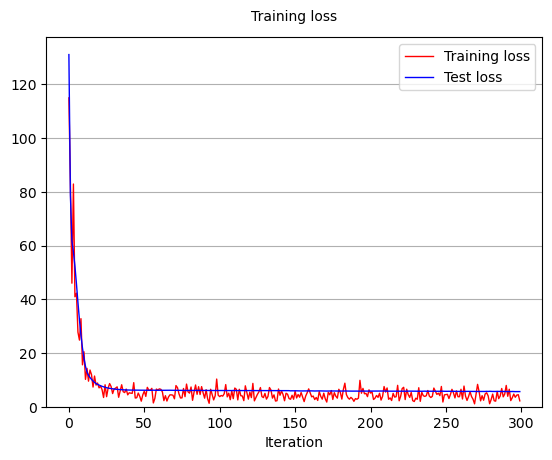

Evaluating error for Johnny_1280x720_60_short.y4m network on test set:
Mean absolute percentage error: 0.18642003600994403
Mean absolute error: 1.1584262364324205
Mean root mean squared error: 2.376089337148219
Running for artificl.tar
[iter: 0 ]: Training Loss: 0.0008
[iter: 25000 ]: Training Loss: 0.0000
[iter: 50000 ]: Training Loss: 0.0000
[iter: 75000 ]: Training Loss: 0.0000
[iter: 100000 ]: Training Loss: 0.0000
[iter: 125000 ]: Training Loss: 0.0000
[iter: 150000 ]: Training Loss: 0.0000
[iter: 175000 ]: Training Loss: 0.0000
[iter: 200000 ]: Training Loss: 0.0000
[iter: 225000 ]: Training Loss: 0.0000
[iter: 250000 ]: Training Loss: 0.0000
[iter: 275000 ]: Training Loss: 0.0000


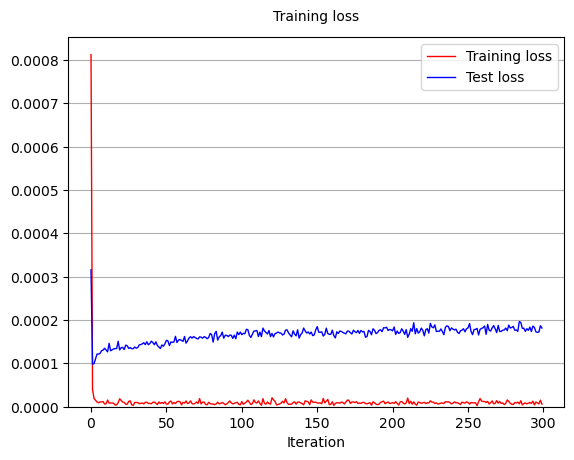

Evaluating error for artificl.tar network on test set:
Mean absolute percentage error: 0.4613770829135965
Mean absolute error: 0.0100040465325738
Mean root mean squared error: 0.013366421163193039
Running for AUFNIRA_z3.637557.smt2
[iter: 0 ]: Training Loss: 70783.5391
[iter: 25000 ]: Training Loss: 1.3770
[iter: 50000 ]: Training Loss: 2.3245
[iter: 75000 ]: Training Loss: 2.1942
[iter: 100000 ]: Training Loss: 1.8892
[iter: 125000 ]: Training Loss: 2.8927
[iter: 150000 ]: Training Loss: 1.2472
[iter: 175000 ]: Training Loss: 1.7765
[iter: 200000 ]: Training Loss: 1.5594
[iter: 225000 ]: Training Loss: 1.7807
[iter: 250000 ]: Training Loss: 1.8066
[iter: 275000 ]: Training Loss: 1.3463


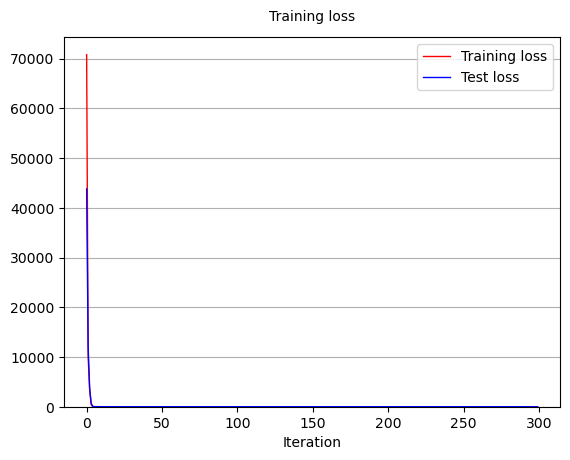

Evaluating error for AUFNIRA_z3.637557.smt2 network on test set:
Mean absolute percentage error: 0.07630091665070095
Mean absolute error: 0.9305312712515144
Mean root mean squared error: 1.2626879610234436


In [44]:
path = str(Path.cwd())
files = ["corona","jpeg-large","smallbank-1","beethoven.wav","ambivert","ambivert.wav.tar","Johnny_1280x720_60_short.y4m","artificl.tar","AUFNIRA_z3.637557.smt2"]
for file in files:

    data = pd.read_csv(path + "/data sets/"+ file +".csv")
    print(f"Running for {file}")
    data_array = data.to_numpy()

    x = data_array[:,:-1]
    y = data_array[:,-1:]

    features =  x.shape[1]
    hidden = int(features * 7.5)
    batch = int(x.shape[0] / 50)
    rng = np.random.RandomState(seed=111111)
    lr = 0
    if file in ["Johnny_1280x720_60_short.y4m", "ambivert.wav.tar", "jpeg-large", "corona", "ambivert"]:
        lr = 3e-5
    else:
        lr = 3e-3
    repetitions = 1
    metrics = np.zeros((repetitions,3))
    for i in range(repetitions):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
        network = Three_layer_network(rng=rng,
                               D_in=features,
                               D_hid_1=hidden)
        training_network(network,
                MSE_loss,
                rng,
                x_train,
                y_train,
                x_test,
                y_test,
                batch_size=batch,
                learning_rate=lr,
                total_iters=300000,
                iters_per_recon_plot=1000)
        print(f"Evaluating error for {file} network on test set:")
        metrics[i] = evaluate(x_test, y_test)
    with open(path + "/data analysis/" + file +" test_set analysis.csv", 'w', newline='') as file_object:
        writer_object = writer(file_object)
        for j  in range(metrics.shape[0]):
            writer_object.writerow(metrics[j])